In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

In [2]:
zero = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
])

one = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
    [0, 1, 0],
])

two = np.array([
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
    [1, 0, 0],
    [1, 1, 1],
])

three = np.array([
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
])

four = np.array([
    [1, 0, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
    [0, 0, 1],
])

five = np.array([
    [1, 1, 1],
    [1, 0, 0],
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
])

six = np.array([
    [1, 1, 1],
    [1, 0, 0],
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
])

seven = np.array([
    [1, 1, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1],
])

eight = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
])

nine = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
    [0, 0, 1],
    [1, 1, 1],
])

nums = [
    zero,
    one,
    two,
    three,
    four,
    five,
    six,
    seven,
    eight,
    nine
]

nums_mtrx = np.array([n.ravel() for n in nums])
np.savetxt('./numbers.txt', nums_mtrx)

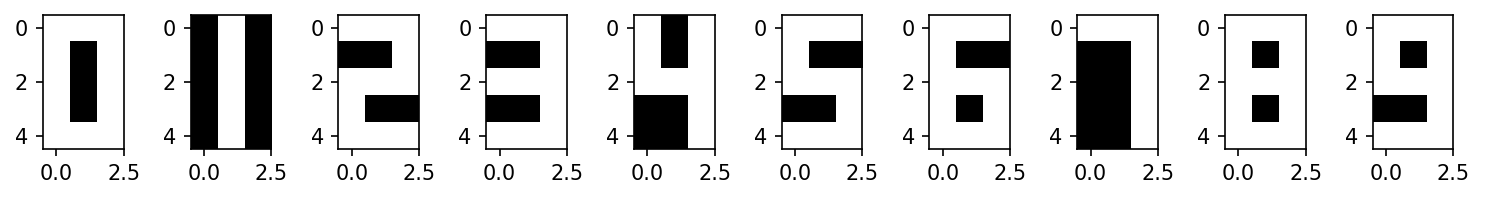

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path('.', 'numbers.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(5, 3), cmap='gray')

plt.tight_layout()
plt.show()

In [4]:
cells_columns = [f'c{n}' for n in range(15)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, 15)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [5]:
test_frac = 0.7

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [6]:
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)


@njit(fastmath=True)
def softmax_jit(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)


@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, w: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)
    
    for i in prange(xBatch.shape[0]):
        y = softmax_jit(xBatch[i] @ w + b)
        dw += np.outer(xBatch[i] ,y - yBatch[i])
        db += y - yBatch[i]
    
    return dw, db

class Perceptron:
    def __init__(self, nIn: int, nOut: int) -> None:
        self.nIn = nIn
        self.nOut = nOut
        self.w: np.ndarray = np.random.uniform(-1, 1, (nIn, nOut))
        self.b: np.ndarray = np.zeros((nOut))

    def predict(self, x:np.ndarray) -> np.ndarray:
        return softmax(x @ self.w + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for j in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)

            dw, db = grads(xTrain[idxs], yTrain[idxs], self.w, self.b)
            
            self.w -= lr*dw
            self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        yPred = np.array([self.predict(xi) for xi in x])
        d = 1/self.nOut * np.linalg.norm(y-yPred, axis=1)
        return 1/x.shape[0] * np.sum(d)

In [7]:
nIn = 15
nOut = 10

learning_rate = 1e-2
batch_size = 30
max_iter = 10000

model = Perceptron(nIn, nOut)

print('untrained loss: ', model.loss(xTest, yTest).round(4))

model.train(
    xTrain,
    yTrain,
    learning_rate,
    batch_size,
    max_iter
)

print('trained loss: ', model.loss(xTest, yTest).round(4))

TP_count = 0
for x,y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print('accuracy: ', round(accuracy, 3))

untrained loss:  0.1057


trained loss:  0.0046
accuracy:  1.0


In [8]:
for i, num in enumerate(nums_mtrx):
    yPred = model.predict(num+np.random.uniform(0, 1, 15)).round(2)
    print(i, yPred, i == np.argmax(yPred))

0 [0.97 0.   0.   0.   0.   0.   0.03 0.   0.   0.  ] True
1 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.01] True
2 [0.   0.   0.93 0.01 0.   0.   0.   0.   0.05 0.  ] True
3 [0.   0.   0.   0.93 0.01 0.   0.   0.   0.05 0.  ] True
4 [0.   0.   0.   0.   0.99 0.   0.   0.   0.01 0.  ] True
5 [0.   0.   0.   0.   0.   0.37 0.63 0.   0.   0.  ] False
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] True
7 [0.   0.   0.   0.01 0.01 0.   0.01 0.97 0.   0.  ] True
8 [0.   0.   0.   0.   0.   0.   0.24 0.   0.76 0.  ] True
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] True


In [9]:
for x,y in zip(xTest, yTest):
    print(y, model.predict(x).round(2))

[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1 0 0 0 0 0 0 0 0 0] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 1 0 0 0 0 0 0 0 0] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 1 0 0 0 0 0 0 0] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0 0 1 0 0 0 0 0 0 0] [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
[0 0 1 0 0 0 0 0 0 0] [0.   0.   0.98 0.   0.   0.   0.   0.   0.02 0.  ]
[0

0 | 0.0
1 | 0.0
2 | 0.0
3 | 0.87
4 | 0.0
5 | 0.01
6 | 0.0
7 | 0.0
8 | 0.0
9 | 0.12


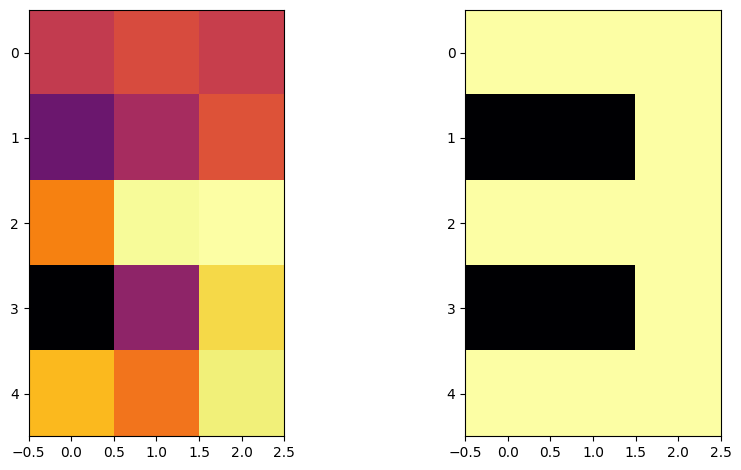

In [33]:
i = random.randint(0,9)

x = nums_mtrx[i]
x_noised = x + np.random.uniform(0, 1, 15)

yPred = model.predict(x_noised)
for i in range(10):
    print(i, '|', round(yPred[i], 2))

fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_dpi(100)
fig.set_figwidth(10)

axes[0].imshow(x_noised.reshape((5,3)), cmap='inferno')
axes[1].imshow(x.reshape((5,3)), cmap='inferno')

plt.tight_layout()
plt.show()